In [33]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import lfilter,butter

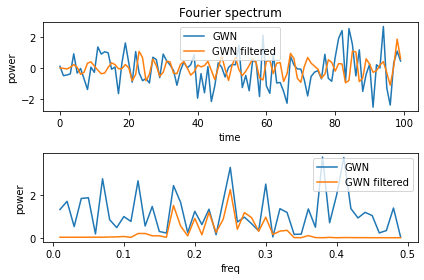

In [109]:
# for loop to calc GWN for all N's
N = np.array([10**2, 10**3, 10**4, 10**5, 10**6])

# First create normal GWN from a random signal x
x = np.array([np.random.normal(0, 1, i) for i in N], dtype=object)
x_fft = np.abs(np.array([np.fft.fft(x[i])/np.sqrt(N[i]) for i in range(5)], dtype=object))**2
freq = np.array([np.fft.fftfreq(N[i]) for i in range(5)], dtype=object)
freq = np.array([freq[i][np.where(freq[i]>0)] for i in range(5)],dtype=object)
GWN = np.array([x_fft[i][np.where(freq[i]>0)] for i in range(5)],dtype=object)
# Now ceate a filtered signal
b,a = butter(3,[0.3,0.6],btype='bandpass') # values Wn for bandpass need to be 0>Wn>1 
x_filter = np.array([lfilter(b,a,x[i]) for i in range(5)],dtype=object)
x_fft_filter = np.abs(np.array([np.fft.fft(x_filter[i])/np.sqrt(N[i]) for i in range(5)], dtype=object))**2
GWN_filter = np.array([x_fft_filter[i][np.where(freq[i]>0)] for i in range(5)],dtype=object)

kkk=0
fig,ax = plt.subplots(nrows=2)

ax[0].plot(x[kkk],label='GWN')
ax[0].plot(x_filter[kkk],label='GWN filtered')
ax[0].set_xlabel('time')
ax[0].set_ylabel('power')
ax[0].set_title('original signal')
ax[0].legend()

ax[1].plot(freq[kkk],GWN[kkk],label='GWN')
ax[1].plot(freq[kkk],GWN_filter[kkk],label='GWN filtered')
ax[1].set_xlabel('freq')
ax[1].set_ylabel('power')
ax[0].set_title('Fourier spectrum')
ax[1].legend()

fig.tight_layout()
